# 1. Choose a labeled text dataset used for classification

In [59]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import  balanced_accuracy_score
from sklearn.model_selection import train_test_split
df = pd.read_csv('amazon_balanced.csv')
df["Sentiment"].value_counts()   # Unbalanced dataset

Sentiment
Positive    82037
Negative    82037
Name: count, dtype: int64

In [2]:
from tabulate import tabulate
def print_relevant_words(pipe):
    words = pipe['vectorizer'].get_feature_names_out()
    print("Vocabulary size", len(words))
    coefs = pipe['model'].coef_
    classes = pipe['model'].classes_

    top_n_words = 10
    sorted_coef_indexes = coefs.argsort(axis=1)

    negative_words = [(words[i], coefs[0, i]) for i in sorted_coef_indexes[0, :top_n_words]]
    positive_words = [(words[i], coefs[0, i]) for i in sorted_coef_indexes[0, -top_n_words:]]

    table = []
    for neg, pos in zip(negative_words, positive_words):
        table.append([f"{neg[0]} | relevance: {neg[1]:.2f}", f"{pos[0]} | relevance: {pos[1]:.2f}"])

    print(tabulate(table, headers=["Negative", "Positive"], tablefmt="grid"))

# 2. Define a classification pipeline and 3. Run and evaluate the classifier

In [71]:
X = df['Review']
label_mapping = {'Positive': 1, 'Negative': 0}
y = df['Sentiment'].map(label_mapping)   # 1 for positive, 0 for negative

In [87]:
from joblib import Parallel, delayed
import numpy as np

def get_train_test_accuracy(pipeline_factory, x_vector, y_vector):
    pipeline = pipeline_factory()
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(x_vector, y_vector, test_size=0.2)
    # Train the pipeline
    pipeline.fit(X_train, y_train)
    # Predict on training set
    y_train_pred = pipeline.predict(X_train)
    train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
    
    # Predict on test set
    y_test_pred = pipeline.predict(X_test)
    test_accuracy = balanced_accuracy_score(y_test, y_test_pred)

    return train_accuracy, test_accuracy

def get_mean_accurancy(pipeline_factory, x_vector, y_vector, n=10, n_jobs = -1):
    results = Parallel(n_jobs=n_jobs)(delayed(get_train_test_accuracy)(pipeline_factory, x_vector, y_vector) for i in range(n))
    results = [result for result in results if result is not None]  # Ensure results are not None

    train_accuracies = np.array([train_accuracy for train_accuracy, _ in results])
    test_accuracies = np.array([test_accuracy for _, test_accuracy in results])
    mean_train_accuracies = np.mean(train_accuracies)
    mean_test_accuracies = np.mean(test_accuracies)

    return mean_train_accuracies, mean_test_accuracies

In [74]:
import re

def normal_pipeline_factory():
    return Pipeline(
        [
            (
                "vectorizer",
                CountVectorizer(
                    preprocessor=lambda x: re.sub(r"[^a-zA-Z\s]", "", x.lower()),
                    binary=True,
                    stop_words="english",
                    min_df=20,
                ),
            ),
            ("model", LogisticRegression(max_iter=1000)),
        ]
    )

pipe_count_binary = normal_pipeline_factory()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe_count_binary.fit(X_train, y_train)
print("Pipe score: ", pipe_count_binary.score(X_test, y_test))
y_pred = pipe_count_binary.predict(X_test)
accuracy = balanced_accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print_relevant_words(pipe_count_binary)
n = 20
train_accuracy, test_accurancy = get_mean_accurancy(normal_pipeline_factory, X, y, n)
print(f"Train accuracy: {train_accuracy:.3f}, Test accuracy: {test_accurancy:.3f} over {n} runs")



Pipe score:  0.8924577175072376
Accuracy:  0.892460134037297
Vocabulary size 10837
+----------------------------------+-------------------------------+
| Negative                         | Positive                      |
+==================================+===============================+
| overrated | relevance: -3.23     | teens | relevance: 1.94       |
+----------------------------------+-------------------------------+
| dissapointing | relevance: -3.03 | unbeatable | relevance: 1.94  |
+----------------------------------+-------------------------------+
| unacceptable | relevance: -2.78  | jimmies | relevance: 2.00     |
+----------------------------------+-------------------------------+
| yuck | relevance: -2.74          | compostable | relevance: 2.01 |
+----------------------------------+-------------------------------+
| cancelled | relevance: -2.63     | addicting | relevance: 2.01   |
+----------------------------------+-------------------------------+
| ahold | relevance:

In [ ]:
# Testing for arbitray text
text_positive = ["This product is unbelievably good"]
text_negative = ["This product is unbelievably bad"]  # For some reason this is classified as positive
prediction_positive = pipe_count_binary.predict(text_positive)
prediction_negative = pipe_count_binary.predict(text_negative)
print("Prediction positive: ", prediction_positive)
print("Prediction negative: ", prediction_negative)

## Lemmatized pipeline (selected as best)

In [4]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
X_lemmatized = X.apply(lambda x: ' '.join([lemmatizer.lemmatize(p) for p in x.lower().split()]))

In [84]:
import re

def lemma_pipeline_factory():
    return Pipeline(
    [
        (
            "vectorizer",
            CountVectorizer(
                preprocessor=lambda x: re.sub(r"[^a-zA-Z\s]", "", x.lower()),
                binary=True,
                stop_words="english",
                min_df=20,
            ),
        ),
        ("model", LogisticRegression(max_iter=1000)),
    ]
)

X_train_lemmatized, X_test_lemmatized, y_train_lemmatized, y_test_lemmatized = (
    train_test_split(X_lemmatized, y, test_size=0.2, random_state=0)
)

# Print vocabulary size

pipe_lemma_count_binary = lemma_pipeline_factory()
pipe_lemma_count_binary.fit(X_train_lemmatized, y_train_lemmatized)
print(
    "Pipe score: ", pipe_lemma_count_binary.score(X_test_lemmatized, y_test_lemmatized)
)
y_pred_lemmatized = pipe_lemma_count_binary.predict(X_test_lemmatized)
accuracy = balanced_accuracy_score(y_test_lemmatized, y_pred_lemmatized)
print("Accuracy: ", accuracy)
print_relevant_words(pipe_lemma_count_binary)
n = 20
train_accuracy, test_accurancy = get_mean_accurancy(lemma_pipeline_factory, X_lemmatized, y, n)
print(f"Train accuracy: {train_accuracy:.3f}, Test accuracy: {test_accurancy:.3f} over {n} runs")

Pipe score:  0.8870028950175225
Accuracy:  0.8870034456951701
Vocabulary size 9612
+----------------------------------+--------------------------------+
| Negative                         | Positive                       |
+==================================+================================+
| overrated | relevance: -3.25     | skeptical | relevance: 2.03    |
+----------------------------------+--------------------------------+
| yikes | relevance: -2.74         | hooked | relevance: 2.07       |
+----------------------------------+--------------------------------+
| weakest | relevance: -2.74       | yum | relevance: 2.08          |
+----------------------------------+--------------------------------+
| dissapointing | relevance: -2.72 | nutritionist | relevance: 2.10 |
+----------------------------------+--------------------------------+
| rediculous | relevance: -2.65    | delish | relevance: 2.17       |
+----------------------------------+--------------------------------+
| yuck 

## Stemmed pipeline

In [47]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")
X_stemmed = X.apply(lambda x: ' '.join([stemmer.stem(p) for p in x.lower().split()]))

In [68]:
X_train_stemmed, X_test_stemmed, y_train_stemmed, y_test_stemmed = train_test_split(
    X_stemmed, y, test_size=0.2
)

def stem_pipeline_factory():
    return Pipeline(
    [
        (
            "vectorizer",
            CountVectorizer(
                preprocessor=lambda x: re.sub(r"[^a-zA-Z\s]", "", x.lower()),
                binary=True,
                stop_words="english",
                min_df=20,
            ),
        ),
        ("model", LogisticRegression(max_iter=1000)),
    ]
)

pipe_stemmed_count = stem_pipeline_factory()
# Print vocabulary size

pipe_stemmed_count.fit(X_train_stemmed, y_train_stemmed)
print("Pipe score: ", pipe_stemmed_count.score(X_test_stemmed, y_test_stemmed))
y_pred_stemmed = pipe_stemmed_count.predict(X_test_stemmed)
accuracy = balanced_accuracy_score(y_test_stemmed, y_pred_stemmed)
print("Accuracy: ", accuracy)
print_relevant_words(pipe_stemmed_count)
n = 20
train_accuracy, test_accurancy = get_mean_accurancy(stem_pipeline_factory, X_stemmed, y, n)
print(f"Train accuracy: {train_accuracy:.3f}, Test accuracy: {test_accurancy:.3f} over {n} runs")


Pipe score:  0.8825841840621667
Accuracy:  0.8825882562149723
Vocabulary size 7663
+-----------------------------+--------------------------------+
| Negative                    | Positive                       |
+=============================+================================+
| boo | relevance: -2.84      | delicaci | relevance: 1.92     |
+-----------------------------+--------------------------------+
| blech | relevance: -2.72    | scotland | relevance: 1.94     |
+-----------------------------+--------------------------------+
| weakest | relevance: -2.62  | snickerdoodl | relevance: 1.96 |
+-----------------------------+--------------------------------+
| yuck | relevance: -2.59     | woof | relevance: 1.97         |
+-----------------------------+--------------------------------+
| overr | relevance: -2.59    | delish | relevance: 2.06       |
+-----------------------------+--------------------------------+
| schar | relevance: -2.54    | deduct | relevance: 2.09       |
+------

### Selected Pipeline: CountVectorizer, Lemmatization and Logistic Regression
#### Reasons 
* Better interpretability
* Smaller vocabulary, less dimensionality
* Small differences between classifier mean accuracy.

# 4. Assess the dataset size

In [103]:
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline


f_list = np.logspace(0, -2.5, 50)

# Function to process one fraction f
def process_fraction(x_vector, y_vector, f, n=20):
    # Sample the dataset
    if float(f) == 1.0:
            X_sample, y_sample = x_vector, y_vector
    else:
        X_sample, _, y_sample, _ = train_test_split(x_vector, y_vector, train_size=float(f))
    train_accuracy, test_accuracy = get_mean_accurancy(lemma_pipeline_factory, X_sample, y_sample, n, n_jobs=-1)

    # Return the average accuracies for this fraction f
    print("Processed fraction", f)
    return train_accuracy, test_accuracy

def get_accuracy_sample(x_vector, y_vector, f_list):
    # Resample the dataset using .sample(frac=f), which gets a fraction of the dataset
    results = Parallel(n_jobs=-1)(delayed(process_fraction)(x_vector, y_vector, f) for f in f_list)
    
    # Separate the train and test accuracies
    train_accuracies, test_accuracies = zip(*results)
    
    return train_accuracies, test_accuracies

train_accuracies, test_accuracies = get_accuracy_sample(X_lemmatized, y, f_list)

Processed fraction 0.27464741148160515
Processed fraction 0.3088843596477481
Processed fraction 0.3473892112083115
Processed fraction 0.3906939937054617
Processed fraction 0.4393970560760791
Processed fraction 0.49417133613238345
Processed fraction 0.2442053094548651
Processed fraction 0.21713743029375185
Processed fraction 0.5557736586486878
Processed fraction 0.193069772888325
Processed fraction 0.17166979066078603
Processed fraction 0.15264179671752334
Processed fraction 0.6250551925273973
Processed fraction 0.13572287829716537
Processed fraction 0.08483428982440722
Processed fraction 0.09540954763499938
Processed fraction 0.1073030940526156
Processed fraction 0.12067926406393285
Processed fraction 0.07543120063354615
Processed fraction 0.06707035611184306
Processed fraction 0.05302611335911987
Processed fraction 0.05963623316594643
Processed fraction 0.04714866363457394
Processed fraction 0.04192267435236916
Processed fraction 0.0372759372031494
Processed fraction 0.029470517025518

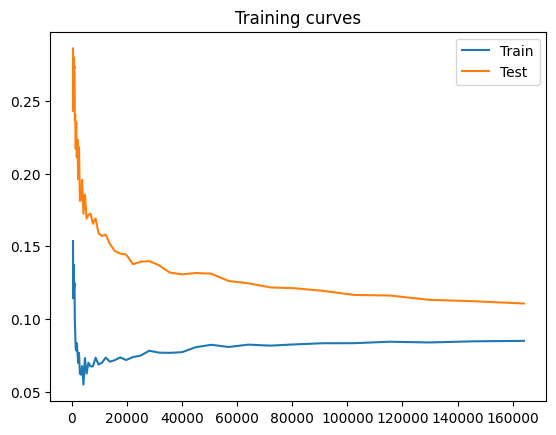

In [104]:
import matplotlib.pyplot as plt

error_train = [1 - x for x in train_accuracies]
error_test = [1 - x for x in test_accuracies]

plt.plot(f_list * len(df), error_train, label='Train')
plt.plot(f_list * len(df), error_test, label='Test')
plt.title("Training curves")
plt.legend()